# Description
In this project, we use the data from kaggle competition [Toxic Comment Classification Challenge by Jigsaw](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data?select=train.csv.zip) and only use the training data. Then we have break this raw training data into train and test data and evaluate the model performances in test data.

The dataset is taken from wikipedia edit text and is classified as one of the following:

1. toxic
2. severe_toxic
3. obscene
4. threat
5. insult
6. identity_hate

This is a multi-label (not-multiclass) classification. One text row has six labels and exactly one label is 1 and other labels are 0.


References:


# Load the Libraries

In [1]:
import os
import sys
import time

time_start_notebook = time.time()

In [2]:
%tensorflow_version 1.x

# bert server needs tf 1.x

TensorFlow 1.x selected.


In [3]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install watermark
    !pip install scikit-plot

In [4]:
%%capture

# Run this only once

# use gpu and tf 1.x to use bert server

!pip install bert-serving-client
!pip install -U bert-serving-server[http]

!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

In [5]:
!ls

sample_data  uncased_L-12_H-768_A-12  uncased_L-12_H-768_A-12.zip


In [6]:
# data science
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# mixed
import os
import time
import random
import subprocess
import joblib
from tqdm import tqdm, trange
from pprint import pprint

# random state
SEED=100
np.random.seed(SEED)

# machine learning
import sklearn
import xgboost as xgb


# model eval
import scikitplot as skplt

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-12-04 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit

numpy      1.18.5
joblib     0.17.0
sklearn    0.22.2.post1
seaborn    0.11.0
scikitplot 0.3.7
watermark  2.0.2
matplotlib 3.2.2
pandas     1.1.4
xgboost    0.90



# Useful Functions

In [7]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

# GPU Testing

In [8]:
!nvidia-smi

Fri Dec  4 18:33:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
TREE_METHOD = 'auto'
try:
    import tensorflow as tf
    has_gpu = tf.test.gpu_device_name()
    TREE_METHOD = 'gpu_hist' if has_gpu else 'auto'
except:
    TREE_METHOD = 'auto'

print(TREE_METHOD)

gpu_hist


## Load Training Data

In [10]:
%%capture
!wget https://github.com/bhishanpdl/Datasets/blob/master/Projects/Jigsaw_Toxic_Comment_Classification/train.csv.zip?raw=true
!unzip train.csv.zip?raw=true

!wget https://github.com/bhishanpdl/Datasets/blob/master/Projects/Jigsaw_Toxic_Comment_Classification/test.csv.zip?raw=true
!unzip test.csv.zip?raw=true

In [11]:
os.listdir()

['.config',
 'uncased_L-12_H-768_A-12',
 'train.csv',
 'test.csv.zip?raw=true',
 'uncased_L-12_H-768_A-12.zip',
 'test.csv',
 'train.csv.zip?raw=true',
 'sample_data']

In [12]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,8d603d50affa1126,"""\nYes, aside, thank you for trying to answer ...",0,0,0,0,0,0
1,8fb3576937b9e0d0,March 2010 (UTC)\n\nThanks! and understood abo...,0,0,0,0,0,0
2,379440e04fb68e27,"""\n\n The Outfield \n\nHahaha - compassion is ...",0,0,0,0,0,0
3,6be4446aac8ae028,Opposition is a source of strength. I believe ...,0,0,0,0,0,0
4,1a2ff7ed958506a3,Please discontinue making those unsupported ch...,0,0,0,0,0,0


In [13]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,70bbc3e96dd459b1,"Hammed it is, cheers!",0,0,0,0,0,0
1,0b2e86f819b4b9a4,"Not a problem, sorry for the inconvenience and...",0,0,0,0,0,0
2,fb7a63a8e287b2d1,Sources for Gambia at the 2000 Summer Olympics...,0,0,0,0,0,0
3,72beff75685cb8dc,Added some criticism \n\nI added some much nee...,0,0,0,0,0,0
4,f7c526a05d03f697,"Who cares? It's just a song, it's a great song...",0,0,0,0,0,0


In [30]:
col_text = 'comment_text'
col_txt = col_text

In [15]:
# unique text
df_train[col_text].nunique(), df_train.shape[0]

(127656, 127656)

In [16]:
# null values
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [17]:
cols_label = ['toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate']

In [18]:
print('Count of 1 per label: \n', df_train[cols_label].sum(), '\n') 
print('Count of 0 per label: \n', df_train[cols_label].eq(0).sum())

Count of 1 per label: 
 toxic            12202
severe_toxic      1282
obscene           6782
threat             379
insult            6292
identity_hate     1136
dtype: int64 

Count of 0 per label: 
 toxic            115454
severe_toxic     126374
obscene          120874
threat           127277
insult           121364
identity_hate    126520
dtype: int64


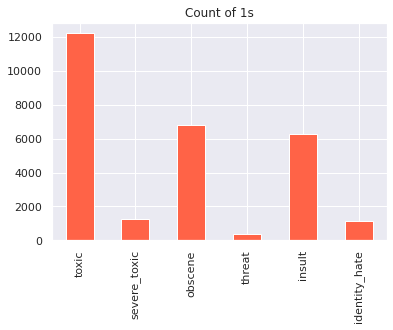

In [19]:
df_train[cols_label].sum().plot.bar(title='Count of 1s',color='tomato');

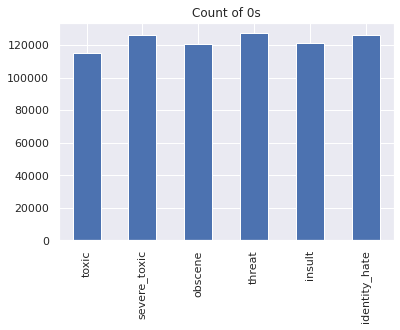

In [20]:
df_train[cols_label].eq(0).sum().plot.bar(title='Count of 0s');

# Data Processing: Training Data

## Shuffle and create ohe column

In [21]:
# shuffle data
df_train = df_train.sample(frac=1,random_state=SEED).reset_index(drop=True)

## Tokenize using Bert Client

In [22]:
from bert_serving.client import BertClient

In [24]:
!nohup bert-serving-start -model_dir=./uncased_L-12_H-768_A-12 -max_seq_len 50 > out.file 2>&1 &

In [25]:
# Start the BERT client
bc = BertClient()

In [68]:
# bc.encode(['this is example text'])

In [69]:
show_methods(bc)

,0,1,2,3
0,close,formatter,pending_response,server_config
1,context,identity,port,server_status
2,encode,ip,port_out,status
3,encode_async,length_limit,receiver,timeout
4,fetch,output_fmt,request_id,token_info_available
5,fetch_all,pending_request,sender,


In [27]:
print(bc.status)
print()
print(bc.server_status)

{'identity': b'8ca80a19-50b8-41e8-be2a-ad7f6f1445f7', 'num_request': 2, 'num_pending_request': 0, 'pending_request': set(), 'output_fmt': 'ndarray', 'port': 5555, 'port_out': 5556, 'server_ip': 'localhost', 'client_version': '1.10.0', 'timeout': -1}

{'client': '8ca80a19-50b8-41e8-be2a-ad7f6f1445f7', 'num_process': 2, 'ventilator -> worker': ['ipc://tmp1bOvpn/socket', 'ipc://tmplEGd7O/socket', 'ipc://tmpuuyWOg/socket', 'ipc://tmpX9rGwI/socket', 'ipc://tmplSWrea/socket', 'ipc://tmpCJqeWB/socket', 'ipc://tmplCn3D3/socket', 'ipc://tmpJHhTlv/socket'], 'worker -> sink': 'ipc://tmpJshcaq/socket', 'ventilator <-> sink': 'ipc://tmpZS0OHV/socket', 'server_current_time': '2020-12-04 18:34:33.814721', 'device_map': [], 'num_concurrent_socket': 8, 'statistic': {'num_data_request': 1, 'num_total_seq': 1, 'num_sys_request': 2, 'num_total_request': 3, 'num_total_client': 1, 'num_active_client': 1, 'avg_request_per_client': 3.0, 'min_request_per_client': 3, 'max_request_per_client': 3, 'num_min_reques

In [31]:
train_text = df_train[col_txt].tolist()
test_text = df_test[col_txt].tolist()

In [32]:
%%time
train_tokenize = bc.encode(train_text)

/usr/local/lib/python3.6/dist-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=50" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


CPU times: user 498 ms, sys: 497 ms, total: 994 ms
Wall time: 6min 37s


In [33]:
%%time
test_tokenize = bc.encode(test_text)

/usr/local/lib/python3.6/dist-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=50" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


CPU times: user 125 ms, sys: 82.4 ms, total: 207 ms
Wall time: 1min 41s


# Modelling: Xgboost

In [39]:
df_train.shape, np.array(train_tokenize).shape

((127656, 8), (127656, 768))

In [50]:
%%time
class_names = ['toxic', 'severe_toxic', 'obscene',
               'threat', 'insult', 'identity_hate']

df_probs = pd.DataFrame(columns=class_names)
params_xgb = dict(max_depth=5, random_state=SEED,tree_method=TREE_METHOD)

for class_name in class_names:
    train_target = df_train[class_name]
    clf = xgb.XGBClassifier(**params_xgb)
    clf.fit(train_tokenize, train_target)

    yprob = clf.predict_proba(test_tokenize)[:,1]
    df_probs[class_name] = yprob

CPU times: user 26.7 s, sys: 21.6 s, total: 48.3 s
Wall time: 48.3 s


In [51]:
df_probs.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.079790,0.003754,0.030732,0.000305,0.022670,0.001376
1,0.003160,0.000180,0.003161,0.000247,0.001889,0.000138
2,0.002050,0.000072,0.001411,0.000097,0.001221,0.000133
3,0.022417,0.000994,0.007981,0.000203,0.006146,0.000409
4,0.081312,0.001272,0.041599,0.000475,0.015619,0.003845


In [53]:
threshold = 0.5
df_preds = df_probs.gt(threshold).astype(np.int8)
df_preds.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


# Model Evaluation

In [54]:
from sklearn import metrics as skmetrics

In [59]:
f1= skmetrics.f1_score(df_test[class_names], df_preds,average='micro')
acc = skmetrics.accuracy_score(df_test[class_names], df_preds)

print(f'F1-score (micro)  : {f1:.4f}')
print(f'Accuracy (overall): {acc:.4f}')

F1-score (micro)  : 0.6201
Accuracy (overall): 0.9080


## Confusion Matrix

In [61]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(df_test[class_names], df_preds)
mcm

array([[[28415,   408],
        [ 1315,  1777]],

       [[31529,    73],
        [  236,    77]],

       [[30022,   226],
        [  753,   914]],

       [[31805,    11],
        [   85,    14]],

       [[30091,   239],
        [  805,   780]],

       [[31624,    22],
        [  234,    35]]])

## Classification Report

In [63]:
clf_report = skmetrics.classification_report(
    df_test[class_names], df_preds,
    target_names=class_names)

print(clf_report)

               precision    recall  f1-score   support

        toxic       0.81      0.57      0.67      3092
 severe_toxic       0.51      0.25      0.33       313
      obscene       0.80      0.55      0.65      1667
       threat       0.56      0.14      0.23        99
       insult       0.77      0.49      0.60      1585
identity_hate       0.61      0.13      0.21       269

    micro avg       0.79      0.51      0.62      7025
    macro avg       0.68      0.36      0.45      7025
 weighted avg       0.78      0.51      0.61      7025
  samples avg       0.05      0.05      0.05      7025



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Co-occurence Matrix

In [66]:
coo = df_test[class_names].T.dot(df_preds)
df_coo = pd.DataFrame(coo, columns=class_names,index=class_names)
df_coo.style.background_gradient()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1777,150,1075,23,975,54
severe_toxic,291,77,268,10,253,19
obscene,1195,145,914,15,800,43
threat,77,12,50,14,51,1
insult,1142,135,813,13,780,45
identity_hate,199,25,143,3,141,35


In [67]:
df_coo2 = df_coo.copy()
df_coo2['Total'] = df_coo2.sum(axis=1)
df_coo2.loc[len(df_coo2),:] = df_coo2.sum(axis=0)
df_coo2.index = df_coo.index.tolist() + ['Total']
df_coo2 = df_coo2.astype(int)

# horizontal is true, vertical is predicted
df_coo2

,toxic,severe_toxic,obscene,threat,insult,identity_hate,Total
toxic,1777,150,1075,23,975,54,4054
severe_toxic,291,77,268,10,253,19,918
obscene,1195,145,914,15,800,43,3112
threat,77,12,50,14,51,1,205
insult,1142,135,813,13,780,45,2928
identity_hate,199,25,143,3,141,35,546
Total,4681,544,3263,78,3000,197,11763


# Time Taken

In [ ]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

# Time taken to run whole notebook: 1 hr 10 min 31 secs